In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy as sp
import asp_func as f

### Functions

In [2]:
def bit_error(bin1, bin2):
    K = min(len(bin1), len(bin2))
    cnt = 0
    for k in range(K):
        if bin1[k] == bin2[k]:
            cnt += 1
    perc = cnt/K * 100
    return f"Correct bits: {np.round(perc,3)}%"

def sign_regressor_LMS(x, d, order, step):
    N = len(x)
    ws = np.zeros((N, order))
    ys = np.zeros(N)
    error = np.zeros(N)
    w = np.zeros(order)
    x_in = np.zeros(order)
    for k in range(N):
        ws[k] = w
        x_in = np.insert(x_in, 0, x[k])
        x_in = np.delete(x_in, -1)
        ys[k] = np.dot(w, x_in)
        error[k] = d[k] - ys[k]
        w = w + 2*step*error[k]*np.sign(x_in)
    return ws, ys, error

def RLS_standard(data, desired, order, forgetting_factor, delta): 
    x, N, λ, δ = data, len(data), forgetting_factor, delta
    x_in = np.zeros(order)[:,np.newaxis]
    w = np.zeros(D)[:,np.newaxis]
    Ψ_inv = np.linalg.inv(np.eye(D) * δ)
    ws = [w]
    ys = []
    error = []
    for n in range(N):
        x_in = np.delete(np.insert(x_in, 0, x[n]), -1)[:,np.newaxis]
        y = np.dot(w.T, x_in)
        #Standard RLS Algorithm
        kn = (Ψ_inv @ x_in) / (λ + x_in.T @ Ψ_inv @ x_in) #Gain vector computation
        err = desired[n] - np.dot(w.T,x_in) #Error estimate
        w = w + kn*err #Weight update
        Ψ_inv = 1/λ * (Ψ_inv - kn@x_in.T@Ψ_inv) #Ψ inverse update
        #Output the trajectories of convergence
        error.append(err)
        ws.append(w)
        ys.append(y)
    return np.squeeze(ws), np.squeeze(ys), np.squeeze(error)

def RLS_num_issues(data, desired, order, forgetting_factor, delta):
    x, N, λ, δ = data, len(data), forgetting_factor, delta
    x_in = np.zeros(order)[:,np.newaxis]
    w = np.zeros(D)[:,np.newaxis] 
    Ψ_inv = np.linalg.inv(np.eye(D) * δ)
    ws = [w]
    ys = []
    error = []
    for n in range(N):
        x_in = np.delete(np.insert(x_in, 0, x[n]), -1)[:,np.newaxis]
        y = np.dot(w.T, x_in)
        #RLS Algorithm - Computation optimized - But not stable for numerical issues
        uT = x_in.T @ Ψ_inv
        kn = uT.T / (λ + x_in.T @ uT.T) #Gain vector computation
        err = desired[n] - np.dot(w.T,x_in) #Error estimate
        w = w + kn*err #Weight update
        Ψ_inv = 1/λ * (Ψ_inv - kn @ uT) #Ψ inverse update
        #Output the trajectories of convergence
        error.append(err)
        ws.append(w)
        ys.append(y)
    return np.squeeze(ws), np.squeeze(ys), np.squeeze(error)

def RLS(data, desired, order, forgetting_factor, delta):
    x, N, λ, δ = data, len(data), forgetting_factor, delta
    x_in = np.zeros(order)[:,np.newaxis]
    w = np.zeros(D)[:,np.newaxis]
    Ψ_inv = np.linalg.inv(np.eye(D) * δ)
    ws = [w]
    ys = []
    error = []
    kns = []
    for n in range(N):
        x_in = np.delete(np.insert(x_in, 0, x[n]), -1)[:,np.newaxis]
        y = np.dot(w.T, x_in)
        #RLS Algorithm - Ensures that Ψ_inv always is symmetric - Numerically stable
        uT = x_in.T @ Ψ_inv
        kn = uT.T / (λ + x_in.T @ uT.T) #Gain vector computation
        err = desired[n] - np.dot(w.T,x_in) #Error estimate
        w = w + kn*err #Weight update
        Ψ_inv = 1/λ * (Ψ_inv - ensure_symm(kn, uT))
        #Output the trajectories of convergence
        error.append(err)
        ws.append(w)
        ys.append(y)
        kns.append(kn)
    return np.squeeze(ws), np.squeeze(ys), np.squeeze(error), np.squeeze(kns)

def ensure_symm(vec1, vec2):
    vec1, vec2 = vec1.squeeze(), vec2.squeeze()
    N1, N2 = len(vec1), len(vec2)
    arr = np.zeros((N1,N2))
    for i in range(N1):
        temp = vec1[i] * vec2[i:]
        arr[i,i:] = temp
        arr[i+1:,i] = temp[1:]
    return arr

### Exercise 5

In [21]:
N = 500
sig_u = 0.003 #Variance of additive noise - Changed to (0.03) get ~30 dB SNR

#-----------------------------------------------------------------------

v = np.random.randn(N) 
b = np.sign(v) #Input Bernoulli sequence

u = np.random.normal(0,np.sqrt(sig_u),N) #Additive noise

H_num = np.array([1])
H_den = np.array([1, -2/3, 2/3])
x = sig.lfilter(H_num, H_den, b) + u #Input sequence after channel effect

b_pow = np.mean(b**2) #Average recieved power
u_pow = np.mean(u**2) #Average noise power

if sig_u != 0:
    SNR = 10*np.log10(b_pow/u_pow)
    print("Signal-To-Noise Ratio:", np.round(SNR,2), "dB")

D = 3 #Order of the the RLS filter
delay = 0 # ????
b_del = f.delay(b, delay) #Delay input as desired signal

Signal-To-Noise Ratio: 25.24 dB


RLS memory: inf samples


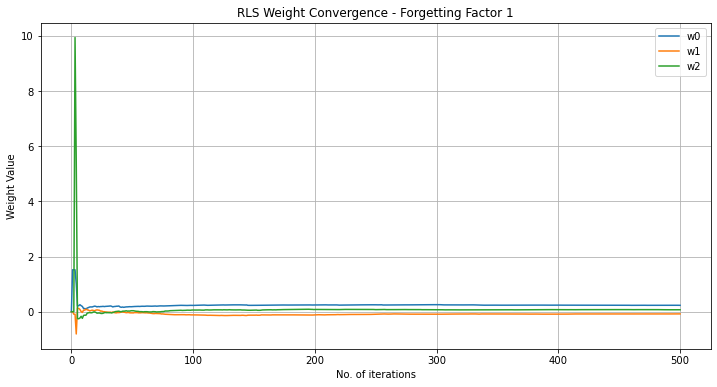

In [4]:
λ = 1 #Forgetting factor
δ = 1e-6
if λ < 1: 
    memory = 1/(1-λ) #Estimate of the 
    print("RLS memory:", np.round(memory,3), "samples")
elif λ == 1:
    print("RLS memory: inf samples")

ws, ys, error, ks = RLS(x, b_del, D, λ, δ)

W_num = np.array(ws[-1])
W_den = np.array([1])

fig, ax = plt.subplots(figsize=(12,6))
for d in range(D):
    ax.plot(ws[:,d], label=f"w{d}")
ax.set_xlabel("No. of iterations")
ax.set_ylabel("Weight Value")
ax.set_title(f"RLS Weight Convergence - Forgetting Factor {λ}")
ax.legend()
ax.grid()
plt.show()

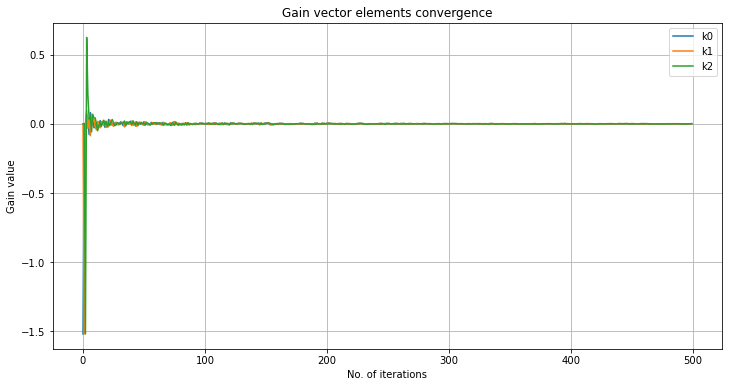

In [5]:
fig, ax = plt.subplots(figsize=(12,6))
for d in range(D):
    ax.plot(ks[:,d], label=f"k{d}")
ax.legend()
ax.set_title("Gain vector elements convergence")
ax.set_xlabel("No. of iterations")
ax.set_ylabel("Gain value")
ax.grid()
plt.show()

[ 0.23135673 -0.0797048   0.07034997]


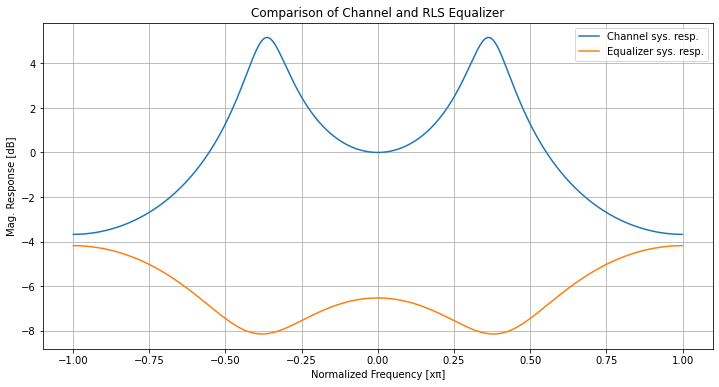

In [6]:
print(W_num)
fig, ax = plt.subplots(figsize=(12,6))
f.plotMagResponse(H_num, H_den, db=True, ax=ax)
f.plotMagResponse(W_num, W_den, db=True, ax=ax)
ax.set_title("Comparison of Channel and RLS Equalizer")
ax.set_xlabel("Normalized Frequency [xπ]")
ax.set_ylabel("Mag. Response [dB]")
ax.legend(("Channel sys. resp.","Equalizer sys. resp."))
ax.grid()
plt.show()

In [7]:
x_qnt = np.sign(x)
y_qnt = np.sign(ys)
print("Before equalization:", bit_error(b, x_qnt))
print("After equalization:", bit_error(b, y_qnt))

Before equalization: Correct bits: 69.6%
After equalization: Correct bits: 71.0%


0.02198149869996177


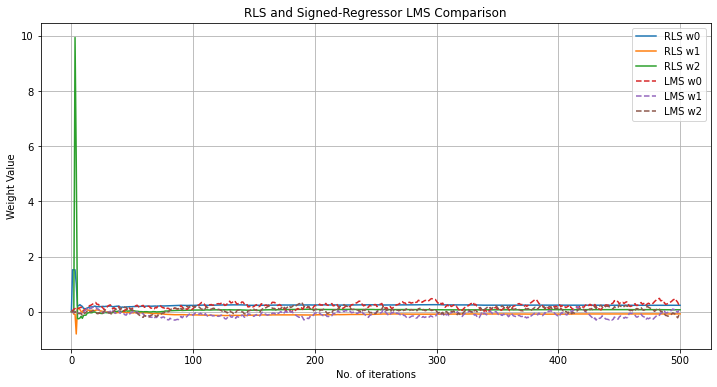

In [8]:
ACR, lags = f.autocorrelation(x, D-1, half=True)
R = sp.linalg.toeplitz(ACR)
μ_max = 1/(3*np.trace(R))
print(μ_max)

lms_order = D
ws_lms, ys_lms, err_lms = sign_regressor_LMS(x, b_del, lms_order, μ_max)

fig, ax = plt.subplots(figsize=(12,6))
for d in range(len(ws[0])):
    ax.plot(ws[:,d], label=f"RLS w{d}")
for d in range(len(ws_lms[0])):
    ax.plot(ws_lms[:,d], label=f"LMS w{d}", linestyle='--')
ax.set_xlabel("No. of iterations")
ax.set_ylabel("Weight Value")
ax.set_title("RLS and Signed-Regressor LMS Comparison")
ax.legend()
ax.grid()
plt.show()

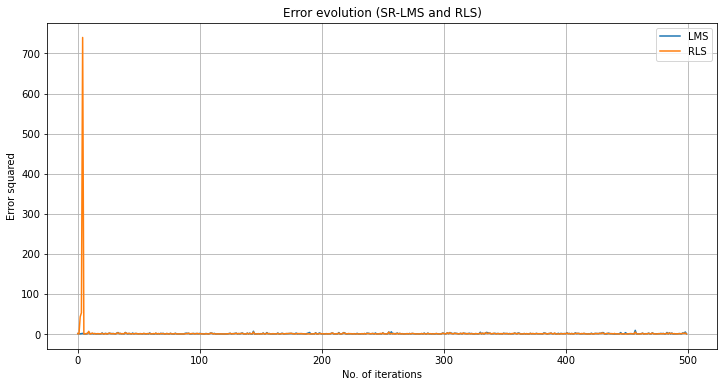

In [9]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(err_lms**2, alpha=1, label="LMS")
ax.plot(error**2, alpha=1, label="RLS")
ax.set_title("Error evolution (SR-LMS and RLS)")
ax.set_xlabel("No. of iterations")
ax.set_ylabel("Error squared")
ax.legend()
ax.grid()
plt.show()

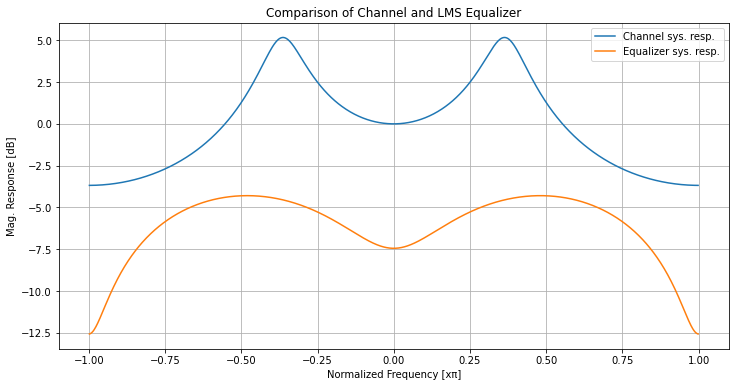

In [10]:
num_lms = np.array(ws_lms[-1])
den_lms = np.array([1])
fig, ax = plt.subplots(figsize=(12,6))
f.plotMagResponse(H_num, H_den, db=True, ax=ax)
f.plotMagResponse(num_lms, den_lms, db=True, ax=ax)
ax.set_title("Comparison of Channel and LMS Equalizer")
ax.set_xlabel("Normalized Frequency [xπ]")
ax.set_ylabel("Mag. Response [dB]")
ax.legend(("Channel sys. resp.","Equalizer sys. resp."))
ax.grid()
plt.show()

In [11]:
print(bit_error(b, np.sign(ys_lms)))

Correct bits: 66.4%


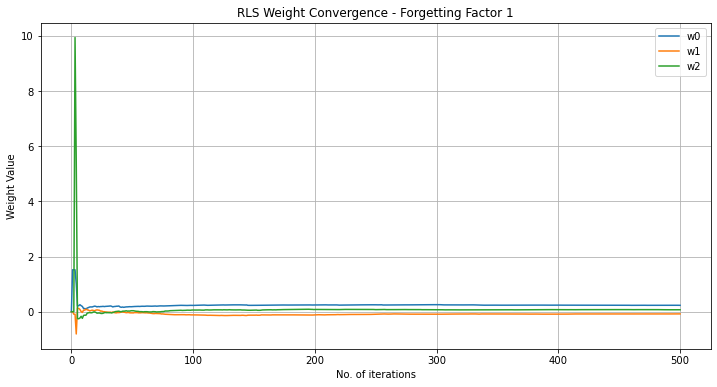

In [12]:
λ_n = 1 #Forgetting factor
δ = 1e-6

ws_nerr, ys_nerr, error_nerr = RLS_num_issues(x, b_del, D, λ_n, δ)
fig, ax = plt.subplots(figsize=(12,6))
for d in range(D):
    ax.plot(ws_nerr[:,d], label=f"w{d}")
ax.set_xlabel("No. of iterations")
ax.set_ylabel("Weight Value")
ax.set_title(f"RLS Weight Convergence - Forgetting Factor {λ_n}")
ax.legend()
ax.grid()
plt.show()

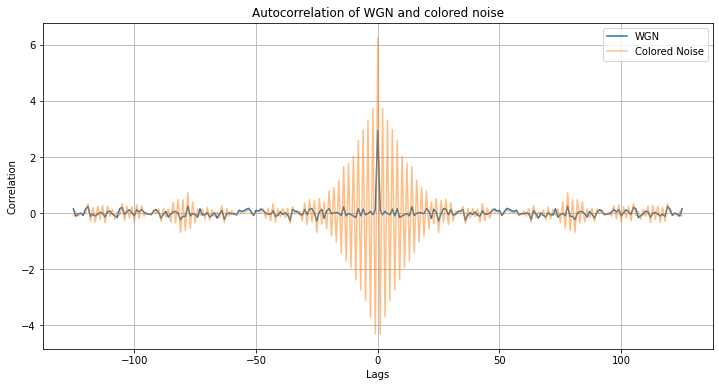

In [13]:
num_n = np.array([1])
den_n = np.array([1,0.5,-0.1,0.2])
col_noise = sig.lfilter(num_n, den_n, u) #Colered noise
acr_noise, lag_noise = f.autocorrelation(u, int(N/4))
acr_col_noise, lag_col_noise = f.autocorrelation(col_noise, int(N/4))

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(lag_noise, acr_noise, label="WGN")
ax.plot(lag_col_noise, acr_col_noise, alpha=0.5, label="Colored Noise")
ax.set_xlabel("Lags")
ax.set_ylabel("Correlation")
ax.set_title("Autocorrelation of WGN and colored noise")
ax.legend()
ax.grid()
plt.show()

RLS memory: 20.0 samples


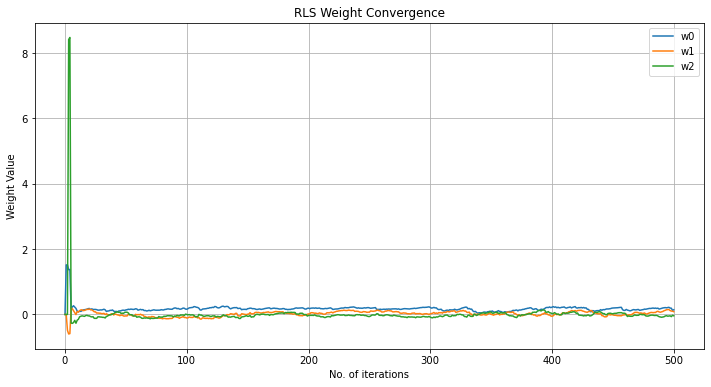

In [14]:
λ = 0.95 #Forgetting factor
δ = 1e-3
memory = 1/(1-λ) #Estimate of the 
x_col = sig.lfilter(H_num, H_den, b) + col_noise 
ws_col, ys_col, error_col, ks_col = RLS(x_col, b_del, D, λ, δ)

W_num_col = np.array(ws_col[-1])
W_den_col = np.array([1])

print("RLS memory:", np.round(memory,3), "samples")

fig, ax = plt.subplots(figsize=(12,6))
for d in range(D):
    ax.plot(ws_col[:,d], label=f"w{d}")
ax.set_xlabel("No. of iterations")
ax.set_ylabel("Weight Value")
ax.set_title("RLS Weight Convergence")
ax.legend()
ax.grid()
plt.show()

0.013115528567882086


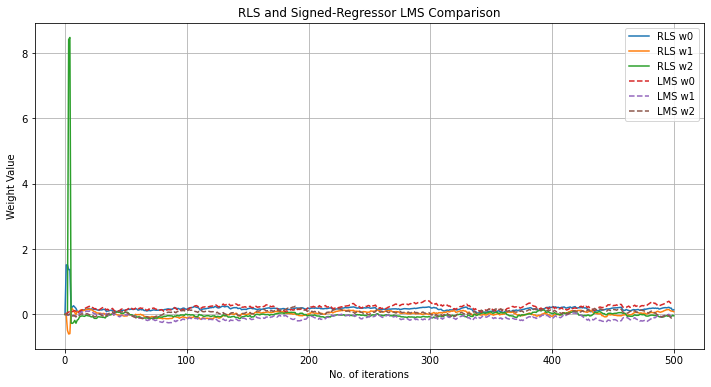

In [15]:
ACR_col, lags_col = f.autocorrelation(x_col, D-1, half=True)
R_col = sp.linalg.toeplitz(ACR_col)
μ_max_col = 1/(3*np.trace(R_col))
print(μ_max_col)
lms_order = D
ws_lms_col, ys_lms_col, err_lms_col = sign_regressor_LMS(x, b_del, lms_order, μ_max_col)

fig, ax = plt.subplots(figsize=(12,6))
for d in range(len(ws_col[0])):
    ax.plot(ws_col[:,d], label=f"RLS w{d}")
for d in range(len(ws_lms_col[0])):
    ax.plot(ws_lms_col[:,d], label=f"LMS w{d}", linestyle='--')
ax.set_xlabel("No. of iterations")
ax.set_ylabel("Weight Value")
ax.set_title("RLS and Signed-Regressor LMS Comparison")
ax.legend()
ax.grid()
plt.show()

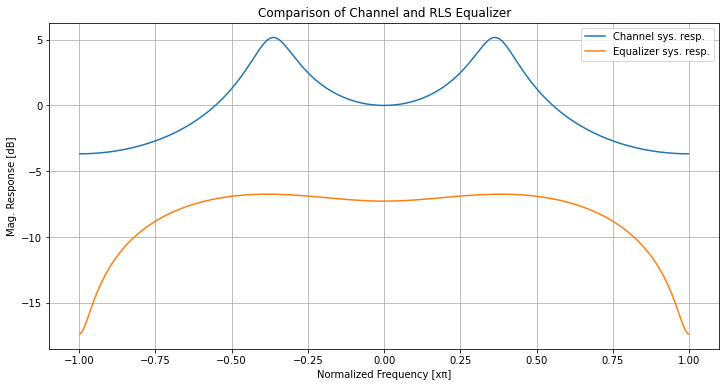

In [16]:
fig, ax = plt.subplots(figsize=(12,6))
f.plotMagResponse(H_num, H_den, db=True, ax=ax)
f.plotMagResponse(W_num_col, W_den_col, db=True, ax=ax)
ax.set_title("Comparison of Channel and RLS Equalizer")
ax.set_xlabel("Normalized Frequency [xπ]")
ax.set_ylabel("Mag. Response [dB]")
ax.legend(("Channel sys. resp.","Equalizer sys. resp."))
ax.grid()
plt.show()

In [17]:
x_col_qnt = np.sign(x_col)
y_col_qnt = np.sign(ys_col)
print("Before equalization:", bit_error(b, x_col_qnt))
print("After equalization:", bit_error(b, y_col_qnt))

Before equalization: Correct bits: 65.6%
After equalization: Correct bits: 62.8%


%timeit RLS(x, b_del, D, λ, δ)
%timeit RLS_standard(x, b_del, D, λ, δ)
%timeit sign_regressor_LMS(x, b_del, lms_order, μ_max)